### original model structure

In [1]:
% reset
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple, end-to-end, LeNet-5-like convolutional MNIST model example.
This should achieve a test error of 0.7%. Please keep this model as simple and
linear as possible, it is meant as a tutorial for simple convolutional models.
Run with --self_test on the command line to execute a short self-test.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.


FLAGS = None


def data_type():
    """Return the type of the activations, weights, and placeholder variables."""
    return tf.float32


def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not tf.gfile.Exists(WORK_DIRECTORY):
        tf.gfile.MakeDirs(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath


def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        return data


def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
    return labels


def fake_data(num_images):
    """Generate a fake dataset that matches the dimensions of MNIST."""
    data = numpy.ndarray(
          shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
          dtype=numpy.float32)
    labels = numpy.zeros(shape=(num_images,), dtype=numpy.int64)
    for image in xrange(num_images):
        label = image % 2
        data[image, :, :, 0] = label - 0.5
        labels[image] = label
    return data, labels


def error_rate(predictions, labels):
    """Return the error rate based on dense predictions and sparse labels."""
    return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])


# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
  data_type(),
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data = tf.placeholder(
  data_type(),
  shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}
# with tf.variable_scope("conv"):
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
conv2_weights = tf.Variable(tf.truncated_normal(
  [5, 5, 32, 64], stddev=0.1,
  seed=SEED, dtype=data_type()))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))
# with tf.variable_scope("fc"):
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED,
                      dtype=data_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                            stddev=0.1,
                                            seed=SEED,
                                            dtype=data_type()))
fc2_biases = tf.Variable(tf.constant(
  0.1, shape=[NUM_LABELS], dtype=data_type()))

# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
              tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=data_type())
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                     0.9).minimize(loss,
                                                   global_step=batch)

# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model(eval_data))

# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = numpy.ndarray(shape=(size, NUM_LABELS), dtype=numpy.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            predictions[begin:end, :] = sess.run(
                eval_prediction,
                feed_dict={eval_data: data[begin:end, ...]})
        else:
            batch_predictions = sess.run(
                eval_prediction,
                feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### restore trained model

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
init = tf.global_variables_initializer()

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

sess.run(init)
data = validation_data[0:256]
label = validation_labels[0:256]

saver = tf.train.Saver()
saver.restore(sess, './LeNet.ckpt')
# predictions = eval_in_batches(data, sess)
# print('Validation error: %.1f%%' % error_rate(predictions, label))

### deconvolution

In [56]:
w1 = sess.run(conv1_weights)
w2 = sess.run(conv2_weights)
w3 = sess.run(fc1_weights)
w4 = sess.run(fc2_weights)

#     data = validation_data[0:256]
#     label = validation_labels[0:256]
data = train_data[0:256]
label = train_labels[0:256]
conv = tf.nn.conv2d(data,
                    conv1_weights,
                    strides=[1, 1, 1, 1],
                    padding='SAME')
# first conv layer activation
act_conv1 = sess.run(tf.nn.relu(tf.nn.bias_add(conv, conv1_biases)))
pool = tf.nn.max_pool(act_conv1,
                      ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1],
                      padding='SAME')
conv = tf.nn.conv2d(pool,
                    conv2_weights,
                    strides=[1, 1, 1, 1],
                    padding='SAME')
act_conv2 = sess.run(tf.nn.bias_add(conv, conv2_biases))
# second conv layer activation
pool = tf.nn.max_pool(act_conv2,
                      ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1],
                      padding='SAME')
pool_shape = pool.get_shape().as_list()
reshape = tf.reshape(
    pool,
    [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
# first fc layer activation
act_fc1 = sess.run(tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases))
# second fc layer activation
act_fc2 = sess.run(tf.nn.softmax(tf.matmul(act_fc1, fc2_weights) + fc2_biases))

predictions = eval_in_batches(data, sess)
print('Validation error: %.1f%%' % error_rate(predictions, label))

Validation error: 0.0%


### transpose convolution in cublas

In [4]:
from theano.sandbox.cuda.basic_ops import gpu_contiguous
from theano.sandbox.cuda.blas import GpuCorrMM
import numpy as np


# upsample
up_w2 = np.zeros((w2.shape[0]*2,w2.shape[1]*2,w2.shape[2],w2.shape[3]))
import scipy.ndimage
for i in range(w2.shape[2]):
    for j in range(w2.shape[3]):
        up_w2[:,:,i,j] = scipy.ndimage.zoom(w2[:,:,i,j], 2, order=0)
up_w2 = up_w2.astype('float32')

ww1 = w1.transpose([2,3,0,1])
contiguous_W1 = gpu_contiguous(ww1)
ww2 = up_w2.transpose([3,2,0,1])
contiguous_W2 = gpu_contiguous(ww2)
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='full')
w1w2 = np.asarray(corr_mm_op(contiguous_W2,contiguous_W1).eval())

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 5.0% of memory, cuDNN 5105)


In [5]:
ww1.shape,ww2.shape,w1w2.shape

((1, 32, 5, 5), (64, 32, 10, 10), (64, 1, 14, 14))

### visualization of the first convolutional layer filter 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

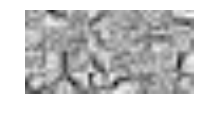

In [7]:
ww = numpy.zeros((4*5,8*5))
for i in range(4):
    for j in range(8):
        ww[5*i:5*(i+1),5*j:5*(j+1)] = w1[:,:,0,8*i+j]
plt.figure(figsize=(3,3))
plt.imshow(ww)
plt.grid('off')
plt.axis('off')
plt.show()

### visualization of the second convolutional layer filter 

(-0.5, 111.5, 111.5, -0.5)

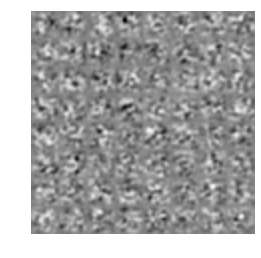

In [8]:
subsize = w1w2.shape[2]
ww = numpy.zeros((8*subsize,8*subsize))
for i in range(8):
    for j in range(8):
        ww[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = w1w2[8*i+j,0,:,:]
plt.figure(figsize=(4,4))
plt.imshow(ww)
plt.grid('off')
plt.axis('off')

### visualization of the first fully connected layer filter 

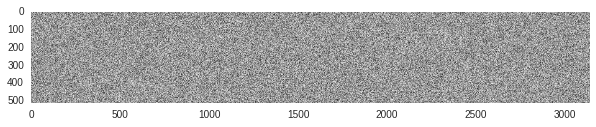

In [9]:
ww = numpy.zeros((8*9,8*9))
plt.figure(figsize=(10,10))
plt.imshow(w3.transpose())
plt.grid('off')
# plt.axis('off')

In [10]:
w3.shape

(3136, 512)

### visualization of the second fully connected layer filter 

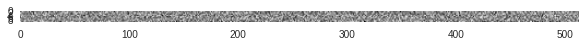

In [11]:
ww = numpy.zeros((8*9,8*9))
plt.figure(figsize=(10,10))
plt.imshow(w4.transpose())
plt.grid('off')
# plt.axis('off')

### visualization of the input image

(-0.5, 27.5, 27.5, -0.5)

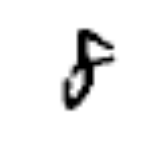

In [12]:
input_idx = 30
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(data[input_idx]))
plt.grid('off')
plt.axis('off')

### visualization of the first convolutional layer activation 

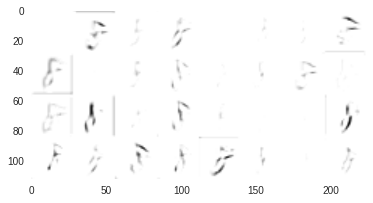

In [13]:
subsize = act_conv1.shape[2]
aa1 = numpy.zeros((4*subsize,8*subsize))
for i in range(4):
    for j in range(8):
        aa1[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = act_conv1[input_idx,:,:,8*i+j]
plt.figure(figsize=(6,6))
plt.imshow(aa1)
plt.grid('off')
# plt.axis('off')

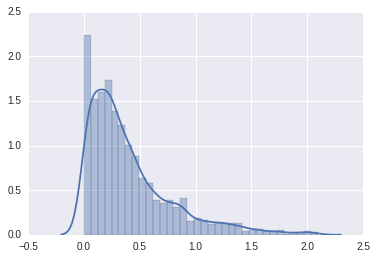

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
a = aa1.flatten()
b = a[a != 0]
plt.figure()
sns.distplot(b)
plt.show()

### visualization of the second convolutional layer activation 

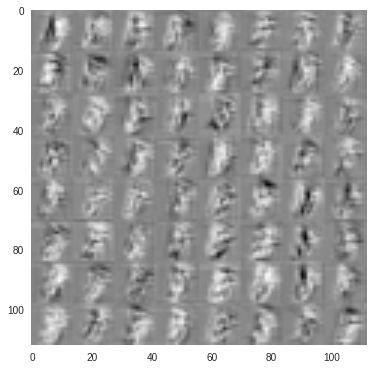

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns 

subsize = act_conv2.shape[2]

aa2 = numpy.zeros((8*subsize,8*subsize))
for i in range(8):
    for j in range(8):
        aa2[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = act_conv2[input_idx,:,:,8*i+j]

plt.figure(figsize=(6,6))
plt.imshow(aa2)
plt.grid('off')
# plt.axis('off')

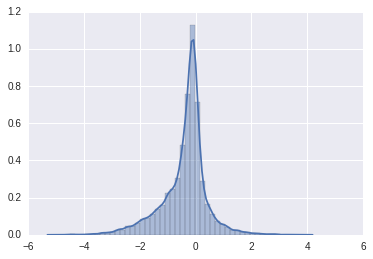

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
a = aa2.flatten()
b = a[a != 0]
plt.figure()
sns.distplot(b)
plt.show()

### visualization of the first fully connected layer activation 

(-0.5, 511.5, 29.5, -0.5)

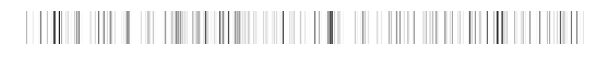

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
plt.imshow(numpy.repeat(numpy.expand_dims(act_fc1[input_idx], axis=1), 30, axis=1).transpose())
plt.grid('off')
plt.axis('off')

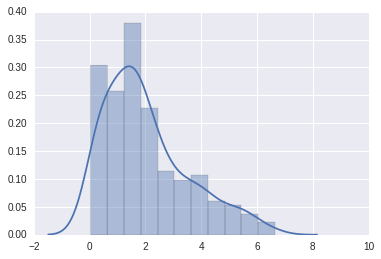

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
a = act_fc1[input_idx]
b = a[a != 0]
plt.figure()
sns.distplot(b.flatten())
plt.show()

### visualization of the second fully connected layer activation 

true label: 8


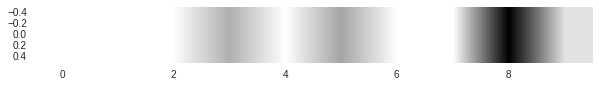

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
plt.imshow(numpy.repeat(numpy.expand_dims(act_fc2[input_idx], axis=1), 1, axis=1).transpose())
plt.grid('off')
# plt.axis('off')
print('true label: {}'.format(label[input_idx]))

### Threshold on activation

In [20]:
w4w3 = np.dot(w4.transpose(),w3.transpose()).reshape(10,7,7,64)

# upsample
up_w4w3 = np.zeros((w4w3.shape[0],w4w3.shape[1]*2,w4w3.shape[2]*2,w4w3.shape[3]))
import scipy.ndimage
for i in range(w4w3.shape[0]):
    for j in range(w4w3.shape[3]):
        up_w4w3[i,:,:,j] = scipy.ndimage.zoom(w4w3[i,:,:,j], 2, order=0)
up_w4w3 = up_w4w3.astype('float32')

# convolution
contiguous_W4W3 = gpu_contiguous(up_w4w3.transpose([0,3,1,2]))
contiguous_W22 = gpu_contiguous(w2.transpose([2,3,0,1]))
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='half')
w4w3w2 = np.asarray(corr_mm_op(contiguous_W4W3,contiguous_W22).eval())

# upsample
up_w4w3w2 = np.zeros((w4w3w2.shape[0],w4w3w2.shape[1],w4w3w2.shape[2]*2,w4w3w2.shape[3]*2))
import scipy.ndimage
for i in range(w4w3w2.shape[0]):
    for j in range(w4w3w2.shape[1]):
        up_w4w3w2[i,j,:,:] = scipy.ndimage.zoom(w4w3w2[i,j,:,:], 2, order=0)
up_w4w3w2 = up_w4w3w2.astype('float32')
        
# convolution
contiguous_W4W3W2 = gpu_contiguous(up_w4w3w2)
contiguous_W11 = gpu_contiguous(w1.transpose([2,3,0,1]))
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='half')
w4w3w2w1 = np.asarray(corr_mm_op(contiguous_W4W3W2,contiguous_W11).eval())

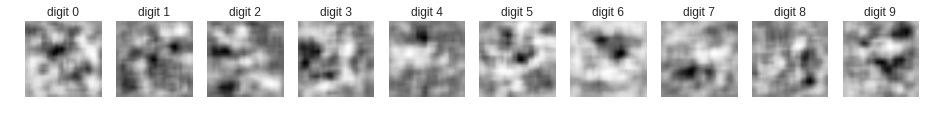

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16,16))
for i in range(10):
    a=fig.add_subplot(1,10,i+1)
    lum_img = np.squeeze(w4w3w2w1[i])
    imgplot = plt.imshow(lum_img)
    a.set_title('digit {}'.format(i))
    plt.axis('off')
    plt.grid('off')

### method 1

layer4 loc: [169 348]
layer4 val: [ 0.18350238  0.18608482]
layer3 loc: [[3071 1065 2054]
 [1094 2070 2023]]
input layer idxi: [[ 4.  5.  6.]
 [ 2.  1.  2.]]
input layer idxi: [[5 1 3]
 [2 5 0]]


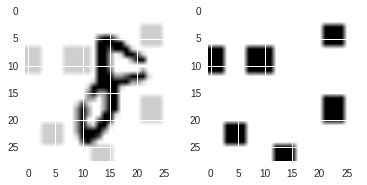

In [44]:
import numpy as np
label = 0

num = 2
if num==1:
    idx4 = np.argsort(w4[:,label])[-num]
else:
    idx4 = np.argsort(w4[:,label])[-num:]
val4 =  w4[idx4,0]
print('layer4 loc: {}'.format(idx4))
print('layer4 val: {}'.format(val4))

num = 3
idx3 = []
for idx4_i in idx4:
    if num==1:
        idx3 = idx3 + [np.argsort(w3[:,idx4_i])[-num]]
    else:
        idx3 = idx3 + [np.argsort(w3[:,idx4_i])[-num:]]
idx3 = np.asarray(idx3)
# val3 =  w3[idx3,idx4]
print('layer3 loc: {}'.format(idx3))
# print('layer3 val: {}'.format(val3))

loc = idx3%(7*7)
idxi,idxj = np.floor(loc/7),loc%7
print('input layer idxi: {}'.format(idxi))
print('input layer idxi: {}'.format(idxj))

plt.figure()
plt.subplot(1,2,1)
mask = np.zeros((7,7))
mask[idxi.astype(int),idxj.tolist()] = 1
largemask = scipy.ndimage.zoom(mask, 4, order=0)
mm = np.multiply(largemask,data[input_idx].reshape(28,28))
mmm = mm
mmm[abs(mm)<1e-6]=-0.8
plt.imshow(mmm+data[input_idx].reshape(28,28))

plt.subplot(1,2,2)
mm[abs(mm)<1e-6]=-0.5
plt.imshow(mm)

### method 2

In [7]:
import theano
import numpy as np
x =theano.tensor.tensor4()
f=theano.function([x],x.flatten())
xx = np.array([[[[1,2],[3,4]],[[5,6],[7,8]]],[[[11,12],[13,14]],[[15,16],[17,18]]]],dtype='float32')
print(xx)
f(xx)

[[[[  1.   2.]
   [  3.   4.]]

  [[  5.   6.]
   [  7.   8.]]]


 [[[ 11.  12.]
   [ 13.  14.]]

  [[ 15.  16.]
   [ 17.  18.]]]]


array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.], dtype=float32)

In [13]:
xx[0,0,0,0],xx[0,0,0,1]

(1.0, 2.0)

In [71]:
reshape = np.eye(64*7*7,dtype='float32')
# first fc layer activation
act_fc1 = sess.run(tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases))
# # second fc layer activation
act_fc2 = sess.run(tf.nn.softmax(tf.matmul(act_fc1, fc2_weights) + fc2_biases))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
aa1 = 
a = aa1.flatten()
b = a[a != 0]
plt.figure()
sns.distplot(b)
plt.show()

In [117]:
aa = np.squeeze(act_fc2[:,[label[input_idx]]])
max_num_idx = np.argsort(aa)[-5:].astype(int)
filter_idx = max_num_idx/(7*7)
filter_loc = max_num_idx%(7*7)
idxi = (filter_loc/7).astype(int)
idxj = filter_loc%7

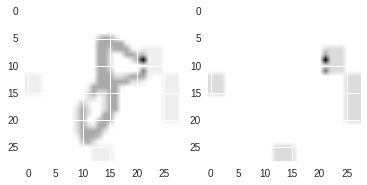

In [119]:
plt.figure()
plt.subplot(1,2,1)
mask = np.zeros((7,7))
mask[idxi.astype(int),idxj.tolist()] = 1
largemask = scipy.ndimage.zoom(mask, 4, order=0)
mm = np.multiply(largemask,data[input_idx].reshape(28,28))
mmm = mm
mmm[abs(mm)<1e-6]=-0.8
plt.imshow(mmm+data[input_idx].reshape(28,28))

plt.subplot(1,2,2)
mm[abs(mm)<1e-6]=-0.5
plt.imshow(mm)